In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from typing import Tuple, List, Optional
from dataclasses import dataclass
from functools import partial

In [2]:
@dataclass
class Gaussian:
    mean: np.ndarray
    cov: np.ndarray

@dataclass
class Observations:
    times: np.ndarray
    obs_ind: np.ndarray  # index of times that are observed
    obs: np.ndarray
    names: List[str]

@dataclass
class KFTracker:
    means: np.ndarray
    covs: np.ndarray
    stds: np.ndarray

In [3]:
def resample(Nsamples, samples, weights):
    """Generate *Nsamples* samples from an empirical distribution defined by *samples* and *weights*

    Inputs
    ------
    Nsamples: integer, number of samples to generate
    samples: (N, d) array of N samples of dimension d that form the empirical distribution
    weights: (N, ) array of N weights

    Returns
    --------
    samples_out: (Nsamples, d) new samples
    weights_out: (Nsamples, ) new weights equal to 1 / N
    """

    N = weights.shape[0]  # get number of points that make up the empirical distribution
    
    # Randomly choose the integers (with replacement) between 0 to N-1 with probabilities given by the weights
    samp_inds = np.random.choice(np.arange(N), Nsamples, p=weights)

    # subselect the samples chosen
    samples_out = samples[samp_inds, :]

    # return uniform weights
    weights_out = np.ones((Nsamples))/Nsamples
    return samples_out, weights_out

In [4]:
def compute_mean_std(samples, weights):
    """Compute the mean and standard deviation of multiple empirical distirbution.

    Inputs
    ------
    samples: (N, d, m) array of samples defining the empirical distribution
    weights: (N, m) array of weights

    Returns
    -------
    means: (m, d) array of means
    stds: (m, d) array of standard deviations

    Notes
    -----
    m is the number of empirical distributions
    """

    N, d, m = samples.shape
    means = np.zeros((m, d))
    stds = np.zeros((m, d))
    for ii in range(m):
        means[ii, :] = np.dot(weights[:, ii], samples[:, :, ii])
        stds[ii, :] = np.sqrt(np.dot(weights[:, ii], (samples[:, :, ii] - np.tile(means[ii, :], (N, 1)))**2))
    return means, stds

In [5]:
def pendulum_dyn(current_state, dt=0.1):

    """Pendulum dynamics

    Inputs
    ------
    Current_state : either (2,) or (N, 2) for vectorized input
    """
    if current_state.ndim == 1:
        next_state = np.zeros((2))
        next_state[0] = current_state[0] + dt * current_state[1]
        next_state[1] = current_state[1] - dt * 9.81 * np.sin(current_state[0])
    else: # multiple inputs
        next_state = np.zeros(current_state.shape)
        next_state[:, 0] = current_state[:, 0] + dt * current_state[:, 1]
        next_state[:, 1] = current_state[:, 1] - dt * 9.81 * np.sin(current_state[:, 0])
    return next_state

def observe(current_state):
    if current_state.ndim == 1:
        out = np.zeros((1))
        out[0] = np.sin(current_state[0])
    else:
        out = np.zeros((current_state.shape[0], 1))
        out[:, 0] = np.sin(current_state[:, 0])
    return out

In [6]:
def step(prop, proppdf, current_samples, current_weights, likelihood, data, propagator, dt, Lproc, proc_var, proc_mat_inv, noise_var):
    """
    Propagate a particle filter

    Inputs
    --------
    prop            - proposal function (current_state, data)
    proppdf         - proposal function logpdf
    current_samples - ensemble of samples
    current_weights - ensemble of weights
    likelihood      - function to evaluate the log likelihood (samples, data)
    data            - Observation
    propagator      - dynamics logpdf

    @returns samples and weights after assimilating the data
    """

    new_samples = prop(current_samples, dt, data, Lproc)
    new_weights = likelihood(new_samples, data, noise_var) + propagator(new_samples, current_samples, dt, data, proc_var, proc_mat_inv) - \
                            proppdf(new_samples, current_samples, dt, data, proc_var, proc_mat_inv)
    
    log_weights = new_weights + np.log(current_weights)
    max_log_weight = np.max(log_weights)
    log_weights -= max_log_weight 
    weights = np.exp(log_weights)
    new_weights = weights / np.sum(weights)
    
    return new_samples, new_weights

In [45]:
def particle_filter(data, prior_mean, prior_cov,
                    prop, proppdf, likelihood, propagator, dt, Lproc, proc_var, proc_mat_inv, noise_var,
                    time_instances_to_store, return_sample_memory=True, nsamples=1000, resampling_threshold_frac=0.1):
    
    """Particle Filter

    Inputs
    -------
    data: (nsteps, m) array of data points, N is the time index, m is the dimensionality of the data
    prior_mean: (d), prior mean
    prior_cov: (d, d), prior mean
    Nsamples: integer, number of samples in the empirical distribution
    resampling_threshold_frac: float between 0 and 1 indicating to resample when effective sample size below frac of nsamples

    Returns
    -------
    samples: (nsamples, d, nsteps)
    weights: (nsamples, nsteps)
    eff: (nsamples), effective sample size

    Notes
    -----
    For documentation of prop, proppdf, likelihood, and propagator -- see the step function
    """
    
    d = prior_mean.shape[0]
    nsteps = data.shape[0]

    # create a sample memory array for storage
    sample_memory = []
    weight_memory = []

    # Allocate memory
    samples = np.zeros((nsamples, d, nsteps+1))
    weights = np.zeros((nsamples, nsteps+1))
    eff = np.zeros((nsteps+1)) # keep track of effective sample size at each step


    # Generate initial samples from the prior
    L = np.linalg.cholesky(prior_cov)
    samples[:, :, 0] = np.tile(prior_mean, (nsamples, 1))+ np.dot(L, np.random.randn(d, nsamples)).T
    weights[:, 0] = 1.0 / nsamples # all weights are equal because of independent sampling from prior
    eff[0] = nsamples

    resamp_threshold = int(nsamples * resampling_threshold_frac)

    for ii in range(1, nsteps+1):
        samples[:, :, ii], weights[:, ii] = step(prop,  proppdf, samples[:, :, ii-1], weights[:, ii-1],
                                                 likelihood, data[ii-1, :], propagator, dt, Lproc, proc_var, proc_mat_inv, noise_var)

        #weights[:, ii] = normalise(weights[:, ii])

        # compute the effective sample size
        eff[ii] = 1.0 / np.sum(weights[:, ii]**2)

        if ii % 50 == 0:
            print("eff = ", ii, eff[ii])

        # resample if effective sample size is below threshold
        if eff[ii] < resamp_threshold:
            samples[:, :, ii], weights[:, ii] = resample(nsamples, samples[:, :, ii], weights[:, ii])
        
        if ii in time_instances_to_store:
            sample_memory.append(samples[:, :, ii])
            weight_memory.append(weights[:, ii])
   
    if return_sample_memory:
        return samples, weights, eff, sample_memory, weight_memory
    else:
        return samples, weights, eff

In [8]:
def proposal(current_state, dt, data, Lproc):
    """ Bootstrap Particle Filter the proposal is the dynamics!"""

    if current_state.ndim == 1:
        return pendulum_dyn(current_state, dt) + np.dot(Lproc, np.random.randn(2))
    else:
        nsamples = current_state.shape[0]
        return pendulum_dyn(current_state, dt) + np.dot(Lproc, np.random.randn(2, nsamples)).T

def proposal_logpdf(current, previous, dt, data, proc_var, proc_mat_inv):
    """ Bootstrap Particle Filter: the proposal is the dynamics"""
    nexts  = pendulum_dyn(previous, dt)
    delta = nexts - current
    if current.ndim == 1:
        return -0.5 * np.dot(delta, np.dot(proc_mat_inv, delta))
    else:
        return -0.5 * np.sum(delta * np.dot(delta, proc_mat_inv.T), axis=1)

def likelihood(state, data, noise_var):
    """Gaussian Likelihood through nonlinear model"""
    dpropose = observe(state)
    delta = dpropose - data
    if state.ndim == 1:
        return -0.5 * np.dot(delta, delta) / noise_var
    else:
        return -0.5 * np.sum(delta * delta, axis=1) / noise_var

## Individual Analysis

eff =  50 67041.60740208607
eff =  100 80015.82809114933
eff =  150 54511.438673147604
eff =  200 57406.06127656168
eff =  250 54586.432230329476
eff =  300 49172.822011982076
eff =  350 85614.34060844296
eff =  400 68609.50456077936
eff =  450 76670.82930174569
eff =  500 58740.51220152111
eff =  50 84243.98451554686
eff =  100 77374.1342057553
eff =  150 75329.99723204054
eff =  200 93827.29033518281
eff =  250 75406.39044160058
eff =  300 82892.40807540812
eff =  350 70295.36258391327
eff =  400 97774.55285342524
eff =  450 62437.69294104822
eff =  500 36.532455716013644
eff =  50 56308.29477273546
eff =  100 81116.80183237612
eff =  150 48590.46311612737
eff =  200 79899.54977527814
eff =  250 92426.06739124547
eff =  300 93292.19427845399
eff =  350 59341.65779371893
eff =  400 61075.36884423989
eff =  450 80918.03654717738
eff =  500 1.0644988326633384


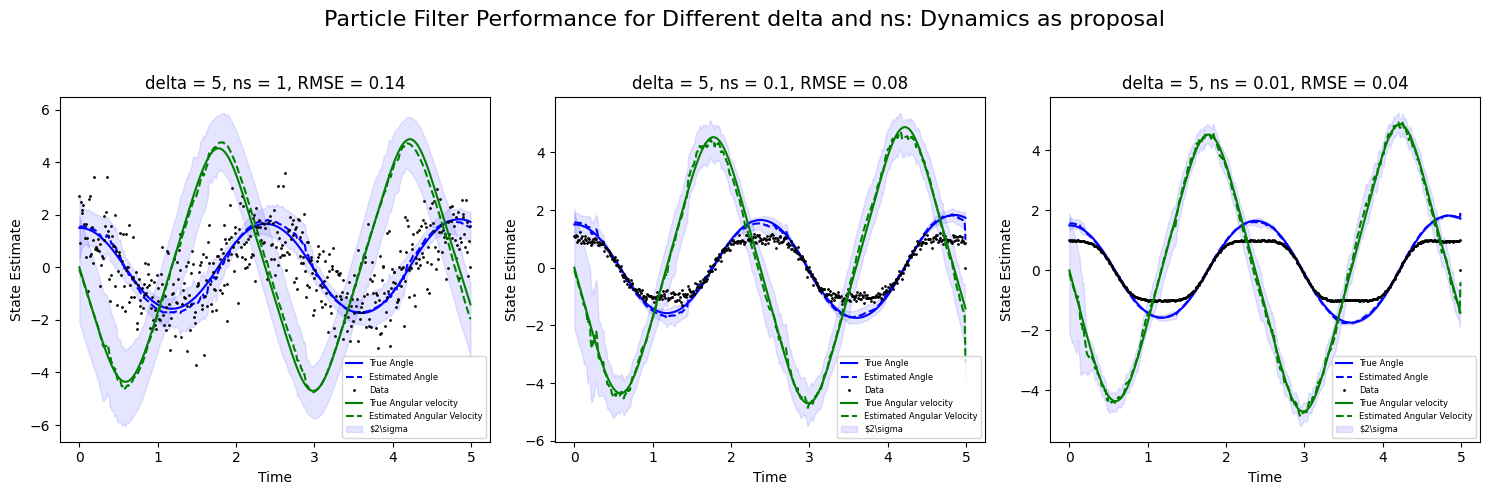

In [ ]:
## Combined Analysis

# Parameters
x0 = np.array([1.5, 0])  # Initial state 
dt = 0.01  # Time step
Nsteps = 500  # Number of time steps
times = np.arange(0, Nsteps*dt, dt)  # Time array
num_samples = 100000  # Number of particles
resample_thresh = 0.5  # Resampling threshold
proc_var = 0.5  # Process noise variance

# Initialize process noise covariance matrix
proc_mat = np.zeros((2, 2))
proc_mat[0, 0] = proc_var / 3.0 * dt**3
proc_mat[0, 1] = proc_var / 2.0 * dt**2
proc_mat[1, 0] = proc_var / 2.0 * dt**2
proc_mat[1, 1] = proc_var * dt
proc_mat_inv = np.linalg.pinv(proc_mat)
Lproc = np.linalg.cholesky(proc_mat)

# create array to store samples
sample_memories = []
weight_memories = []
time_instances_to_store = np.array([60, 140, 220, 300, 380])
return_sample_memory = True


# Combinations of delta and ns
delta_values = [1]
ns_values = [1, 0.1, 0.01]

# Prepare the plot
if len(delta_values) == 1 and len(ns_values) == 1:
    fig, axs = plt.subplots(1, 1, figsize=(6, 5))
    fig.suptitle("Particle Filter Performance", fontsize=16)
else:
    fig, axs = plt.subplots(len(delta_values), len(ns_values), figsize=(15, 5))
    fig.suptitle("Particle Filter Performance for Different delta and ns: Dynamics as proposal", fontsize=16)

# Loop over delta and ns
for i, delta in enumerate(delta_values):
    for j, ns in enumerate(ns_values):
        noise_var = ns * ns  # Variance of observation noise
        obs_ind = np.arange(0, Nsteps, delta)  # Observation indices
        data = np.zeros((len(obs_ind), 1))  # Observed data

        # Generate truth and observations
        true = np.zeros((Nsteps, 2))
        true[0, :] = x0
        obs_counter = 0

        for ii in range(1, Nsteps):
            true[ii, :] = pendulum_dyn(true[ii-1, :], dt=dt)
            if ii in obs_ind:
                data[obs_counter] = observe(true[ii, :]) + np.random.randn() * ns
                obs_counter += 1

        # Run particle filter
        if return_sample_memory == False:
            samples, weights, eff = particle_filter(
            data, true[0, :], np.eye(2), proposal, proposal_logpdf,
            likelihood, proposal_logpdf, dt, Lproc, proc_var, proc_mat_inv,
            noise_var, time_instances_to_store, return_sample_memory,nsamples=num_samples, resampling_threshold_frac=resample_thresh)
        else:
            samples, weights, eff, sample_memory, weight_memory = particle_filter(
            data, true[0, :], np.eye(2), proposal, proposal_logpdf,
            likelihood, proposal_logpdf, dt, Lproc, proc_var, proc_mat_inv,
            noise_var, time_instances_to_store, return_sample_memory,nsamples=num_samples, resampling_threshold_frac=resample_thresh)

            sample_memories.append(sample_memory)
            weight_memories.append(weight_memory)

        means, stds = compute_mean_std(samples, weights)

        # Compute RMSE
        RMSE = np.sqrt(np.mean((means[1:, 0] - true[obs_ind, 0])**2))

        if len(delta_values) == 1 and len(ns_values) == 1:
            axs.plot(times, true[:, 0], 'b-', label='True Angle')
            axs.plot(times[obs_ind], means[1:, 0], 'b--', label='Estimated Angle')
            axs.plot(times[obs_ind], data[:, 0], 'ko', ms=1, label='Data')
            axs.fill_between(times[obs_ind],
                        means[1:, 0] - 2 * stds[1:, 0],
                        means[1:, 0] + 2 * stds[1:, 0],
                        color='blue', alpha=0.1)
            
            axs.plot(times, true[:, 1], 'g-', label='True Angular velocity')
            axs.plot(times[obs_ind], means[1:, 1], 'g--', label='Estimated Angular Velocity')
            axs.fill_between(times[obs_ind],
                        means[1:, 1] - 2 * stds[1:, 1],
                        means[1:, 1] + 2 * stds[1:, 1],
                        color='blue', alpha=0.1, label=r'$2\sigma')
            
            axs.set_title(f"delta = {5}, ns = {ns}, RMSE = {RMSE:.2f}")
            axs.set_xlabel("Time")
            axs.set_ylabel("State Estimate")
            axs.legend(fontsize=6)

        elif len(delta_values) == 1 and len(ns_values) > 1:
            # Plot results
            ax = axs[j]
            ax.plot(times, true[:, 0], 'b-', label='True Angle')
            ax.plot(times[obs_ind], means[1:, 0], 'b--', label='Estimated Angle')
            ax.plot(times[obs_ind], data[:, 0], 'ko', ms=1, label='Data')
            ax.fill_between(times[obs_ind],
                        means[1:, 0] - 2 * stds[1:, 0],
                        means[1:, 0] + 2 * stds[1:, 0],
                        color='blue', alpha=0.1)
            
            ax.plot(times, true[:, 1], 'g-', label='True Angular velocity')
            ax.plot(times[obs_ind], means[1:, 1], 'g--', label='Estimated Angular Velocity')
            ax.fill_between(times[obs_ind],
                        means[1:, 1] - 2 * stds[1:, 1],
                        means[1:, 1] + 2 * stds[1:, 1],
                        color='blue', alpha=0.1, label=r'$2\sigma')

            ax.set_title(f"delta = {5}, ns = {ns}, RMSE = {RMSE:.2f}")
            ax.set_xlabel("Time")
            ax.set_ylabel("State Estimate")
            ax.legend(fontsize=6)

        else:
            # Plot results
            ax = axs[i, j]
            ax.plot(times, true[:, 0], 'b-', label='True Angle')
            ax.plot(times[obs_ind], means[1:, 0], 'b--',  label='Estimated Angle')
            ax.plot(times[obs_ind], data[:, 0], 'ko', ms=1, label='Data')
            ax.fill_between(times[obs_ind],
                        means[1:, 0] - 2 * stds[1:, 0],
                        means[1:, 0] + 2 * stds[1:, 0],
                        color='blue', alpha=0.1)

            ax.plot(times, true[:, 1], 'g-', label='True Angular velocity')
            ax.plot(times[obs_ind], means[1:, 1], 'g--', label='Estimated Angular Velocity')
            ax.fill_between(times[obs_ind],
                        means[1:, 1] - 2 * stds[1:, 1],
                        means[1:, 1] + 2 * stds[1:, 1],
                        color='blue', alpha=0.1, label=r'$2\sigma$')

            ax.set_title(f"delta = {delta}, ns = {ns}, RMSE = {RMSE:.2f}")
            ax.set_xlabel("Time")
            ax.set_ylabel("State Estimate")
            ax.legend(fontsize=6)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [47]:
# load the kf_results.pkl file
import pickle
with open("kf_results.pkl", "rb") as f:
    kf_results = pickle.load(f)

In [48]:
# extract means and covariances for the time_instances_to_store
kf_means = []
kf_covs = []
for ii in range(len(kf_results)):
    kf_means_l2 = []
    kf_covs_l2 = []
    for jj in range(len(kf_results[ii].means)):
        if jj in time_instances_to_store:
            kf_means_l2.append(kf_results[ii].means[jj])
            kf_covs_l2.append(kf_results[ii].covs[jj])
    kf_means.append(kf_means_l2)
    kf_covs.append(kf_covs_l2)

C:\Users\soham\AppData\Local\Temp\ipykernel_18928\1631039712.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[j].legend()


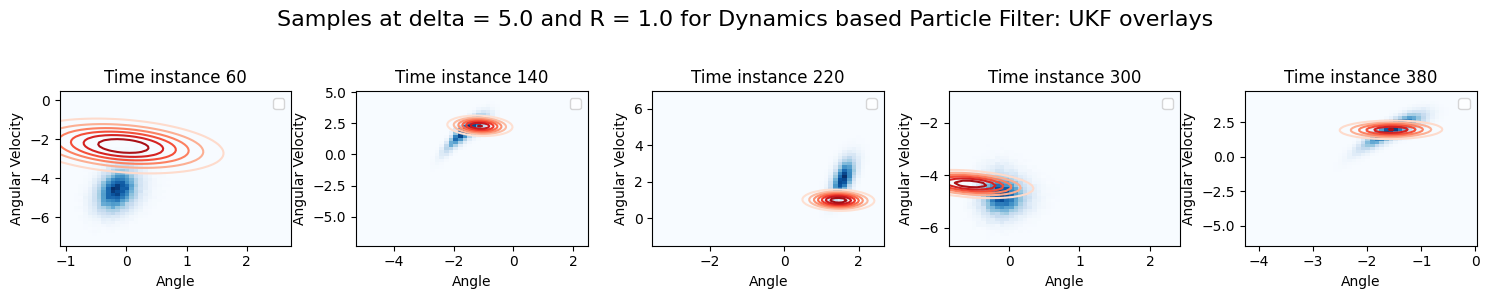

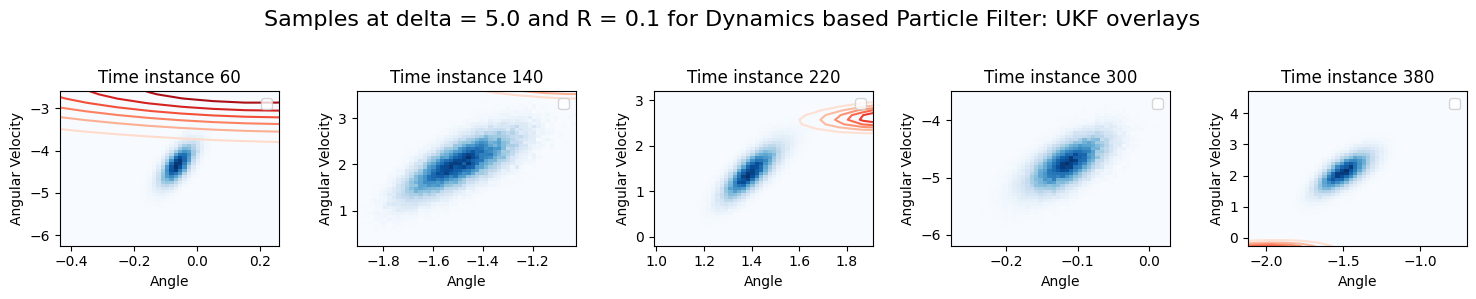

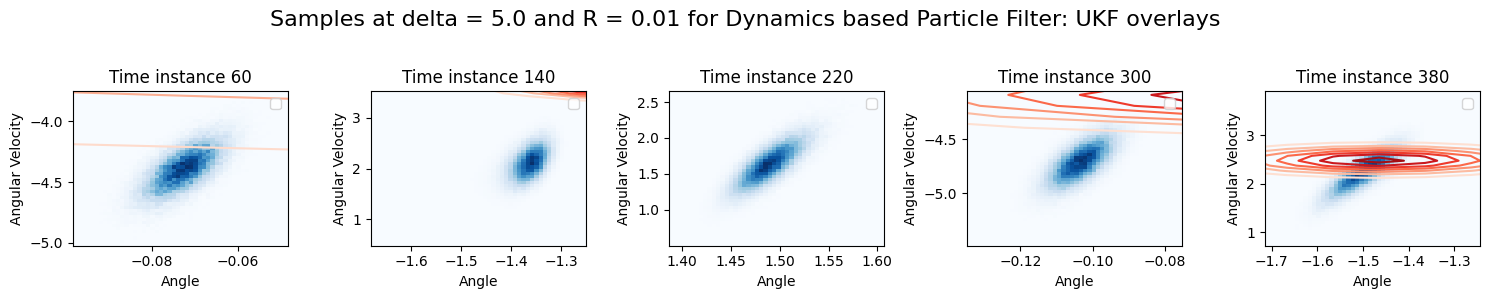

In [51]:
sample_memories = np.array(sample_memories)
weight_memories = np.array(weight_memories)
bins =  np.array([50, 50, 50])
delta_R_pair = np.array([[5, 1], [5, 0.1], [5, 0.01]])

for i in range(len(sample_memories)):
    fig, axs = plt.subplots(1, 5, figsize=(15, 3))
    fig.suptitle(f"Samples at delta = {delta_R_pair[i][0]} and R = {delta_R_pair[i][1]} for Dynamics based Particle Filter: UKF overlays", fontsize=16)
    for j in range(5):

        # plot 2D histogram
        axs[j].hist2d(sample_memories[i][j][:, 0], sample_memories[i][j][:, 1], bins=bins[i], weights = weight_memories[i][j], cmap='Blues')
        axs[j].set_xlabel("Angle")
        axs[j].set_ylabel("Angular Velocity")
        axs[j].set_title(f"Time instance {time_instances_to_store[j]}")
        axs[j].legend()

        # overlay the 2D gaussian with means kf_means and covariances kf_covs
        kf_means_l3, kf_covs_l3 = kf_means[i], kf_covs[i]
        X, Y = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
        pos  = np.dstack((X, Y))
        rv = stats.multivariate_normal(kf_means_l3[j], kf_covs_l3[j])
        Z = rv.pdf(pos)
        axs[j].contour(X, Y, Z, cmap='Reds')
        

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

## Moments Analysis

In [ ]:
# moments analysis
samples = sample_memories[0][2]
weights1 = weight_memories[0][2]

time_instance = time_instances_to_store[2]

# fit a 2D gaussian to the samples
mean = samples.mean(axis=0)
cov = np.cov(samples.T)

# LOAD UKF results
with open("kf_results.pkl", "rb") as f:
    ukf_results = pickle.load(f)

# extract relevant KF_tracker objects
ukf_tracker = ukf_results[0]

# extract means and covariances for the time_instances_to_store
ukf_mean = ukf_tracker.means[time_instance]
ukf_cov = ukf_tracker.covs[time_instance]

# Load EKF results
with open("kf_results_ekf.pkl", "rb") as f:
    ekf_results = pickle.load(f)

# extract relevant KF_tracker objects
ekf_tracker = ekf_results[0]

# extract means and covariances for the time_instances_to_store
ekf_mean = ekf_tracker.means[time_instance]
ekf_cov = ekf_tracker.covs[time_instance]

# Load GHKF results
with open("ghkf_results.pkl", "rb") as f:
    ghkf_results = pickle.load(f)

# extract relevant KF_tracker objects
ghkf_tracker = ghkf_results[0]

# extract means and covariances for the time_instances_to_store
ghkf_mean = ghkf_tracker.means[time_instance]
ghkf_cov = ghkf_tracker.covs[time_instance]

In [110]:
# compare the EKF, UKF, GHKF means and covariances with the particle filter
print("EKF mean: ", ekf_mean)
print("EKF cov: ", ekf_cov)
print("UKF mean: ", ukf_mean)
print("UKF cov: ", ukf_cov)
print("GHKF mean: ", ghkf_mean)
print("GHKF cov: ", ghkf_cov)
print("PF mean: ", mean)
print("PF cov: ", cov)

EKF mean:  [1.33829281 4.12066185]
EKF cov:  [[0.18688869 0.06497574]
 [0.06497574 2.17332593]]
UKF mean:  [1.45213191 0.97918803]
UKF cov:  [[ 0.22708471 -0.00787562]
 [-0.00787562  0.08222446]]
GHKF mean:  [1.5030128  1.66222946]
GHKF cov:  [[0.00151749 0.00086337]
 [0.00086337 0.00148558]]
PF mean:  [1.1393417  2.06090514]
PF cov:  [[ 0.34679289 -0.46206511]
 [-0.46206511  2.03866024]]


eff =  50 947.7021679067608
eff =  100 803.6205013179276
eff =  150 946.5535567392872
eff =  200 952.0598420002069
eff =  250 750.5100032111471
eff =  300 607.5002103117064
eff =  350 991.0377261465579
eff =  400 636.77407058351
eff =  450 894.8376856553499
eff =  500 843.9420065828489
eff =  50 4216.944517865293
eff =  100 3439.5383907511305
eff =  150 4764.735181272959
eff =  200 2652.839093696846
eff =  250 3592.959953468584
eff =  300 3083.157272964138
eff =  350 4711.810746760035
eff =  400 3216.2628446187837
eff =  450 3284.615620127303
eff =  500 2693.433843325036
eff =  50 7099.592325854918
eff =  100 6675.507984737089
eff =  150 7238.351443413843
eff =  200 6826.628620521736
eff =  250 6431.171001922677
eff =  300 6822.103575811022
eff =  350 9093.034978082045
eff =  400 7058.944647555279
eff =  450 6684.331229089137
eff =  500 6514.856098222842
eff =  50 14102.864397507105
eff =  100 16797.025507694445
eff =  150 14463.105840306464
eff =  200 17826.343389898837
eff =  250 170

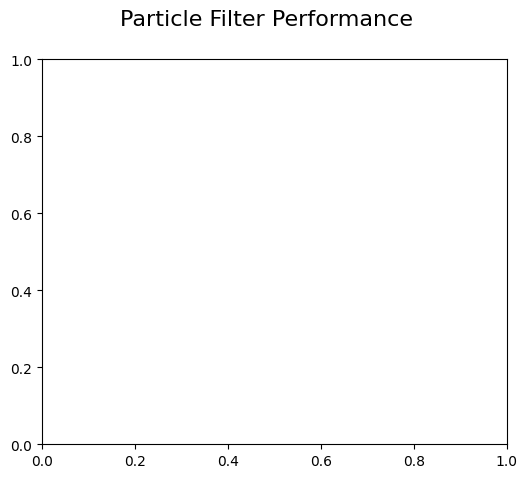

In [ ]:
## Convergence Analysis with number of samples

# Parameters
x0 = np.array([1.5, 0])  # Initial state 
dt = 0.01  # Time step
Nsteps = 500  # Number of time steps
times = np.arange(0, Nsteps*dt, dt)  # Time array
num_samples = np.array([1000, 5000, 10000, 20000, 30000, 50000, 75000, 100000, 200000, 300000, 500000])  # Number of particles
resample_thresh = 0.5  # Resampling threshold
proc_var = 0.5  # Process noise variance

# Initialize process noise covariance matrix
proc_mat = np.zeros((2, 2))
proc_mat[0, 0] = proc_var / 3.0 * dt**3
proc_mat[0, 1] = proc_var / 2.0 * dt**2
proc_mat[1, 0] = proc_var / 2.0 * dt**2
proc_mat[1, 1] = proc_var * dt
proc_mat_inv = np.linalg.pinv(proc_mat)
Lproc = np.linalg.cholesky(proc_mat)

# create array to store samples
sample_memories = []
weight_memories = []
time_instances_to_store = np.array([60, 140, 220, 300, 380])
return_sample_memory = True


# Combinations of delta and ns
delta_values = [1]
ns_values = [1]

# Prepare the plot
if len(delta_values) == 1 and len(ns_values) == 1:
    fig, axs = plt.subplots(1, 1, figsize=(6, 5))
    fig.suptitle("Particle Filter Performance", fontsize=16)
else:
    fig, axs = plt.subplots(len(delta_values), len(ns_values), figsize=(15, 5))
    fig.suptitle("Particle Filter Performance for Different delta and ns: Dynamics as proposal", fontsize=16)

# Loop over delta and ns
for q in range(len(num_samples)):
    for i, delta in enumerate(delta_values):
        for j, ns in enumerate(ns_values):
            noise_var = ns * ns  # Variance of observation noise
            obs_ind = np.arange(0, Nsteps, delta)  # Observation indices
            data = np.zeros((len(obs_ind), 1))  # Observed data

            # Generate truth and observations
            true = np.zeros((Nsteps, 2))
            true[0, :] = x0
            obs_counter = 0

            for ii in range(1, Nsteps):
                true[ii, :] = pendulum_dyn(true[ii-1, :], dt=dt)
                if ii in obs_ind:
                    data[obs_counter] = observe(true[ii, :]) + np.random.randn() * ns
                    obs_counter += 1

            # Run particle filter
            if return_sample_memory == False:
                samples, weights, eff = particle_filter(
                data, true[0, :], np.eye(2), proposal, proposal_logpdf,
                likelihood, proposal_logpdf, dt, Lproc, proc_var, proc_mat_inv,
                noise_var, time_instances_to_store, return_sample_memory,nsamples=num_samples[q], resampling_threshold_frac=resample_thresh)
            else:
                samples, weights, eff, sample_memory, weight_memory = particle_filter(
                data, true[0, :], np.eye(2), proposal, proposal_logpdf,
                likelihood, proposal_logpdf, dt, Lproc, proc_var, proc_mat_inv,
                noise_var, time_instances_to_store, return_sample_memory,nsamples=num_samples[q], resampling_threshold_frac=resample_thresh)

                sample_memories.append(sample_memory)
                weight_memories.append(weight_memory)

            means, stds = compute_mean_std(samples, weights)

            # Compute RMSE
            RMSE = np.sqrt(np.mean((means[1:, 0] - true[obs_ind, 0])**2))

In [123]:
means_convergence, covs_convergence = [], []
for i in range(len(sample_memories)):
    samples = sample_memories[i][-1]
    weights = weight_memories[i][-1]
    means_convergence.append(samples.mean(axis=0))
    covs_convergence.append(np.cov(samples.T))

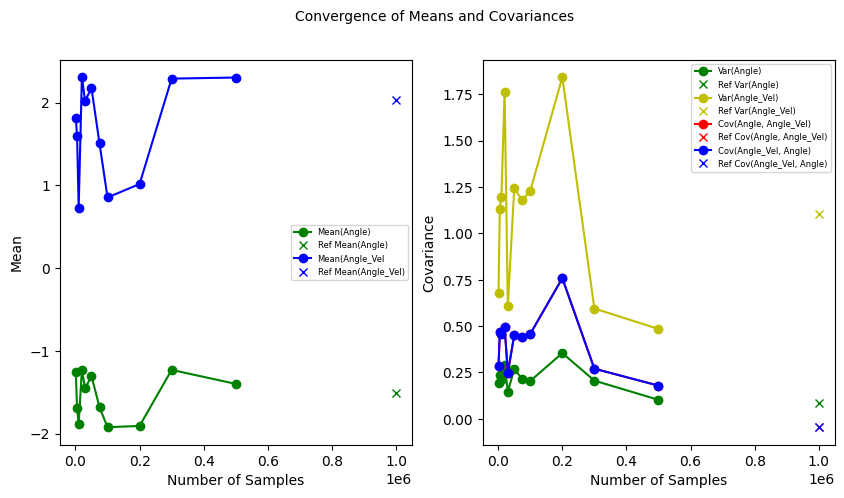

In [134]:
means_convergence = np.array(means_convergence)
covs_convergence = np.array(covs_convergence)

# plot the convergence of the means and covariances
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("Convergence of Means and Covariances", fontsize=10)
axs[0].plot(num_samples, means_convergence[:, 0], 'go-', label='Mean(Angle)')
axs[0].plot(1000000, -1.51400629, 'gx', label='Ref Mean(Angle)')

axs[0].plot(num_samples, means_convergence[:, 1], 'bo-', label='Mean(Angle_Vel')
axs[0].plot(1000000, 2.03158388, 'bx', label='Ref Mean(Angle_Vel)')

axs[0].set_xlabel("Number of Samples")
axs[0].set_ylabel("Mean")
axs[0].legend(fontsize=6)

axs[1].plot(num_samples, covs_convergence[:, 0, 0], 'go-', label='Var(Angle)')
axs[1].plot(1000000, 0.08276041, 'gx', label='Ref Var(Angle)')

axs[1].plot(num_samples, covs_convergence[:, 1, 1], 'yo-', label='Var(Angle_Vel)')
axs[1].plot(1000000, 1.10602866, 'yx', label='Ref Var(Angle_Vel)')

axs[1].plot(num_samples, covs_convergence[:, 0, 1], 'ro-', label='Cov(Angle, Angle_Vel)')
axs[1].plot(1000000, -0.04532614, 'rx', label='Ref Cov(Angle, Angle_Vel)')

axs[1].plot(num_samples, covs_convergence[:, 1, 0], 'bo-', label='Cov(Angle_Vel, Angle)')
axs[1].plot(1000000, -0.04532614, 'bx', label='Ref Cov(Angle_Vel, Angle)')

axs[1].set_xlabel("Number of Samples")
axs[1].set_ylabel("Covariance")
axs[1].legend(fontsize=6)


